# USGS basic land elevation data

<b>Table of Contents</b>

- Overview
- Setup
    - Get authentication token
- Data layer
- Querying the data layer
    - Point query
    - Raster query
- References
  
## Overview

The basic land elevation data is sourced from the National Elevation Dataset (NED) of the United States Geological Survey (USGS). Let us get a practical understanding about this dataset and its usage through this tutorial.

## Setup

Before starting, you have to install IBM EI Geospatial python SDK i.e ibmpairs and other modules needed to run this sample, mentioned in the cell below.

<b>Note:</b> To run this notebook seamlessly, you have to first configure your Geospatial APIs' credentials in a file named `secrets.ini` in the below format:

```
[EI]
api.api_key = <Your Geospatial APIs API key>
api.tenant_id = <Your Geospatial APIs Tenant ID>
api.org_id = <Your Geospatial APIs Org ID>
```

Keep the secrets.ini file at an appropriate relative location of this notebook. For example, as specified in the below config.

```config.read('../../../../auth/secrets.ini')```

In [ ]:
%pip install ibmpairs
%pip install configparser
%pip install matplotlib

In [2]:
import ibmpairs.client as client
import ibmpairs.catalog as catalog
import ibmpairs.query as query
import pandas as pd
import configparser
import json
import numpy as np
from PIL import Image
from IPython import display
import matplotlib.pyplot as plt
import os

Now, let us create a client object using the API_KEY, TENANT_ID (or CLIENT_ID) and ORG_ID to create an authenticated HTTP client Authentication token using 'ibmpairs.client' module, to use it in the subsequent steps.

### Get authentication token

In [4]:
config = configparser.RawConfigParser()
config.read('../../../../auth/secrets.ini')
# Best practice is not to include secrets in source code so we read
# an api key, tenant id and org id from a secrets.ini file.
# You could set the credentials in-line here but we don't
# recommend it for security reasons.

EI_API_KEY    = config.get('EI', 'api.api_key')
EI_TENANT_ID  = config.get('EI', 'api.tenant_id') 
EI_ORG_ID     = config.get('EI', 'api.org_id')  

EI_client_v3  = client.get_client(api_key   = EI_API_KEY,
                                    tenant_id = EI_TENANT_ID,
                                    org_id    = EI_ORG_ID,
                                    legacy    = False,
                                    version   = 3
                                   )

2025-01-20 16:54:49 - paw - INFO - The client authentication method is assumed to be OAuth2.
2025-01-20 16:54:49 - paw - INFO - Legacy Environment is False
2025-01-20 16:54:49 - paw - INFO - The authentication api key type is assumed to be IBM EIS, because the api key prefix 'PHX' is present.
2025-01-20 16:54:51 - paw - INFO - Authentication success.
2025-01-20 16:54:51 - paw - INFO - HOST: https://api.ibm.com/geospatial/run/na/core/v3


## Data layer
We shall start by querying the catalog to retrieve the Data Set ID and the Data Layer that forms the dataset.

In [7]:
pd.set_option('display.max_colwidth', None)
search_df=catalog.search("USGS basic land elevation data")
search_df[['dataset_id','data_layer_id','data_layer_name','data_layer_description_short','data_layer_level','data_layer_type','data_layer_unit','data_set_name','data_set_description_short']]

,dataset_id,data_layer_id,data_layer_name,data_layer_description_short,data_layer_level,data_layer_type,data_layer_unit,data_set_name,data_set_description_short
0,14,140,USA elevation,USA Digital Elevation Map,23,Raster,m,USGS basic land elevation data,Basic land elevation data from the National Elevation Dataset (NED) of the United States Geological Survey (USGS).


As seen above, the Data Set of ID 14 has a single Data Layer with ID 140 . To gain a better understanding of the Data Set and its geospatial and temporal coverage as well as other relevant metadata, we can make further queries to the catalog submodule as mentioned in the [tutorials](https://ibm.github.io/ibmpairs/tutorials/quickstart/quickstartcatalog.html).

## Querying the data layer

### Point query
Next, we shall make a point query for locations in different parts of the USA to observe their elevation value.

In [20]:
query_result = query.submit(
    {
        "layers" : [
            {
                "type" : "raster", 
                "id" : "140"
            }
        ],
        "spatial" : {
            "type" : "point",
            "coordinates" : [
                "29.16767705372483", "-89.24839765815922",    #Mississippi River delta
                "36.042519", "-82.835764",                    #Blue Ridge Mountains, North Carolina
                "34.857220", "-111.812226",                   #Great Smoky Mountains, North Carolina and Tennessee
                "38.094382", "-119.473812",                   #Sierra Nevada Mountains, California
                "46.85316809870772", "-121.76042806562555"    #Mount Rainier Summit, Washington
            ] 
        },
        "temporal" : {
            "intervals" : [
                {
                    "start" : "2013-01-01T00:00:00Z", 
                    "end" : "2013-01-01T00:00:00Z"
                }
            ]
        }
    } , client=EI_client_v3)

point_df = query_result.point_data_as_dataframe()
point_df['datetime'] = pd.to_datetime(point_df['timestamp'] , unit='ms', errors = 'coerce')
point_df['datetime'] = point_df['datetime'].dt.strftime('%Y-%m-%dT%H:%M:%SZ')
point_df = point_df.drop(columns=['timestamp'])
point_df

2025-01-13 12:10:16 - paw - INFO - TASK: submit STARTING.
2025-01-13 12:10:33 - paw - INFO - TASK: submit COMPLETED.


,layer_id,layer_name,dataset,longitude,latitude,value,datetime
0,140,USA elevation,USGS basic land elevation data,-89.248398,29.167677,0.7126309871673584,2013-01-01T00:00:00Z
1,140,USA elevation,USGS basic land elevation data,-111.812226,34.857220,1319.536376953125,2013-01-01T00:00:00Z
2,140,USA elevation,USGS basic land elevation data,-82.835764,36.042519,563.732177734375,2013-01-01T00:00:00Z
3,140,USA elevation,USGS basic land elevation data,-119.473812,38.094382,2960.233154296875,2013-01-01T00:00:00Z
4,140,USA elevation,USGS basic land elevation data,-121.760428,46.853168,4383.63525390625,2013-01-01T00:00:00Z


We see above, the elevation value in metres for various locations we queried for. For instance, the location we queried within the Blue ridge mountains has an elevation of around 563 meters above sea level.
Note: The comments within the query JSON, intended for descriptive purposes, may cause compatibility issues in other programming languages and should be removed when using the data in those contexts.

### Raster query
Next, we shall make a raster query for the area comprising of Blue Ridge mountains and the nearby Fontana lake, to observe the change in elevation, with the change in terrain. 

In [8]:
NEDResult = query.submit_check_status_and_download(
    {
        "publish": True,
        "name": "Elevation for Blue Ridge mountains and the nearby Fontana lake",
        "spatial": {
            "type": "square",
            "coordinates": [
              35.43590209027983,
              -83.69799480891234,
              35.49325664893964,
              -83.63063739374273
            ]
        },
        "temporal": {
            "intervals": [
              {
                "start": "2013-01-01T00:00:00Z",
                "end": "2013-01-01T23:00:00Z"
              }
            ]
        },
        "layers": [
            {
              "type": "raster",
              "id": "140",
              "output": True
            }
        ]
    }, client=EI_client_v3)

2025-01-16 17:34:43 - paw - INFO - TASK: submit_check_status_and_download STARTING.
2025-01-16 17:34:44 - paw - INFO - The query was successfully submitted with the id: 1737028800_00284469.
2025-01-16 17:34:46 - paw - INFO - The query 1737028800_00284469 has the status Queued.
2025-01-16 17:35:17 - paw - INFO - The query 1737028800_00284469 has the status Running.
2025-01-16 17:35:48 - paw - INFO - The query 1737028800_00284469 has the status Succeeded.
2025-01-16 17:35:48 - paw - INFO - The query 1737028800_00284469 was successful after checking the status.
2025-01-16 17:36:21 - paw - INFO - The query 1737028800_00284469 has the status Succeeded.
2025-01-16 17:36:21 - paw - INFO - The query 1737028800_00284469 was successful after checking the status.
2025-01-16 17:36:21 - paw - INFO - The query download folder is set to the path /Users/environmental-intelligence/Environmental-Intelligence-internal/geospatial_analytics/v3_apis/samples/industry_use_cases/datasets/ned_elevation/download

The query takes a few seconds to complete and downloads the output as a zip file in the /download folder within the same location as this notebook. Now let us display the resultant tiff using the following utility function.

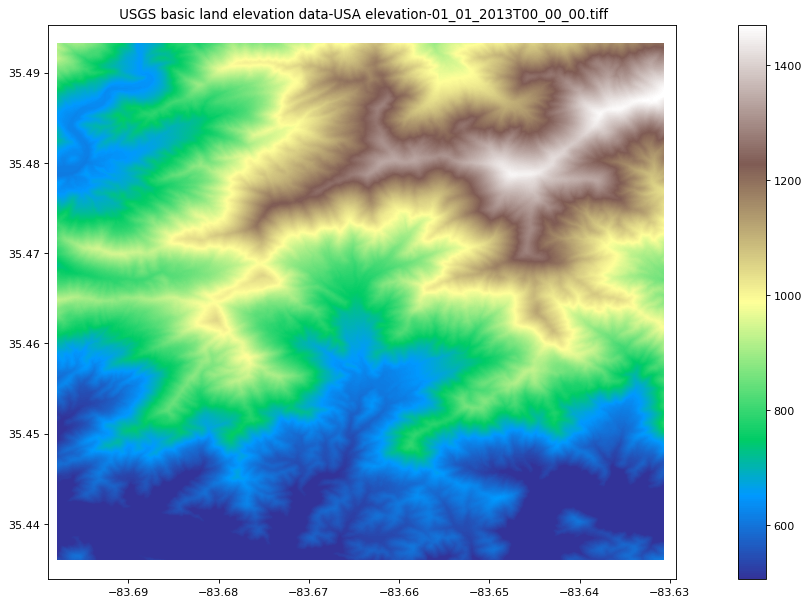

In [9]:
# Function to display the resulting Tiff(s).
NEDResult_file_list = NEDResult.list_files()
for file in NEDResult_file_list:
    if file.endswith('.tiff'): #display the raster images
        with open(file+'.json', 'r') as summary_file:
            fileparms = json.load(summary_file)
        boundingBox=fileparms["boundingBox"]
        pixelStatistics=fileparms["rasterStatistics"]
        myextent=[boundingBox["minLongitude"],
                  boundingBox["maxLongitude"],
                  boundingBox["minLatitude"],
                  boundingBox["maxLatitude"]]  
        arrayNED = np.array(Image.open(file))
        mask = (arrayNED == -9999)
        # Masked array to exclude NO Data points from plotting
        masked_array = np.ma.masked_array(arrayNED, mask)
        plt.figure(figsize = (20, 9), dpi=80) # Sets the size and resolution of the plot
        plt.imshow(masked_array,
                   cmap = 'terrain', 
                   vmin=pixelStatistics["pixelMin"], 
                   vmax=pixelStatistics["pixelMax"],
                   extent = myextent) # Loads the raster data and sets the colormap
        plt.colorbar() # Adds the color bar
        plt.title(" "+os.path.basename(file)) 
        output_image_path = os.path.splitext(os.path.basename(file))[0] + ".png"

        # Save the figure
        plt.savefig(output_image_path, bbox_inches='tight')
        plt.close()
display.Image(output_image_path)

The blue area denotes the lake and low lying areas with an elevation ranging from 0 - 700 metres above sea level, which transitions to green and yellow areas with an elevation between 700 - 1000 meters above sea level, denoting inclined areas. As the elevation increases, we see further color transition to brown and white denoting the higher altitudes and mountain peak with higher elevations above 1000 to more than 1400 meters above sea level.

### References
- https://www.usgs.gov/publications/national-elevation-dataset
- https://gdg.sc.egov.usda.gov/Catalog/ProductDescription/NED.html